In [42]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import split_dataset, create_sequences, root_mean_squared_error, plot_metrics

weekly = pd.read_csv('../../../Dataset/Boulder_Weekly.csv')
weekly['Date'] = pd.to_datetime(weekly['Date'])
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           239 non-null    datetime64[ns]
 1   Energy__kWh_   239 non-null    float64       
 2   Day            239 non-null    int64         
 3   Minimum T      239 non-null    int64         
 4   Maximum T      239 non-null    int64         
 5   Snow           239 non-null    float64       
 6   Precipitation  239 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 13.2 KB


In [43]:
if weekly['Date'].is_monotonic_increasing == False:
    weekly.sort_values(by='Date', ascending=True, inplace=True)

weekly['Month'] = weekly['Date'].dt.month_name()
weekly.drop(columns={'Date', 'Day'}, inplace=True)

    Scale the Dataset with MinMaxScaler / One-Hot Encode and Extract the Entire Scaled Dataset

In [44]:
# Define the columns we need to scale
columns_to_scale = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']

# MinMax scaling for numerical columns
scaler = MinMaxScaler()
weekly_scaled = weekly.copy()
weekly_scaled[columns_to_scale] = scaler.fit_transform(weekly[columns_to_scale])

# Define the columns we need to use for One-Hot Encoding
categorical_columns = ['Month']

# One-hot encoding for 'Weekday' and 'Month'
onehot_encoder = OneHotEncoder(sparse=False)
categorical_encoded = onehot_encoder.fit_transform(weekly[categorical_columns])

# Get the feature names from the encoder
encoded_columns = []
for col, values in zip(categorical_columns, onehot_encoder.categories_):
    encoded_columns.extend([f'{col}_{value}' for value in values])

# Create DataFrame with encoded columns
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Concatenate the new encoded columns to the original DataFrame
weekly_scaled = pd.concat([weekly_scaled, categorical_encoded_df], axis=1)

# Drop the original categorical columns
weekly_scaled = weekly_scaled.drop(categorical_columns, axis=1)
weekly_scaled.columns

Index(['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September'],
      dtype='object')

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [45]:
train_weekly_scaled, val_weekly_scaled, test_weekly_scaled = split_dataset(weekly_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.699
Validation split ratio: 0.197
Testing split ratio:    0.105

Shapes of the datasets:
(167, 17) (47, 17) (25, 17)


    Create sequences for the Transformer model

In [46]:
sequence_length = 24
num_features = len(weekly_scaled.columns)

# Create the training, validation, and test data sequences
train_data_inputs, train_data_targets = create_sequences(train_weekly_scaled, sequence_length)
val_data_inputs, val_data_targets = create_sequences(val_weekly_scaled, sequence_length)
test_data_inputs, test_data_targets = create_sequences(test_weekly_scaled, sequence_length)

Dataset split into sequences:
Sequences shape: (143, 24, 17)
Targets shape: (143,)

Dataset split into sequences:
Sequences shape: (23, 24, 17)
Targets shape: (23,)

Dataset split into sequences:
Sequences shape: (1, 24, 17)
Targets shape: (1,)



    Create the Transformer Model

In [47]:
%run "../Time2Vec/Time2Vec_Transformer.ipynb"

In [48]:
# Define the hyperparameters of the manual model
num_features = len(weekly_scaled.columns)
n_heads = 1
ff_dim = 64
num_layers = 3
d_k = 256 # dimensions of keys
d_v = 256 # dimensions of values

# Create the transformer model
model = Time2VecTranformer(d_k, d_v, n_heads, ff_dim, num_layers, sequence_length, num_features)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 24, 17)]     0           []                               
                                                                                                  
 time2_vector_4 (Time2Vector)   (None, 24, 2)        96          ['input_5[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 24, 19)       0           ['input_5[0][0]',                
                                                                  'time2_vector_4[0][0]']         
                                                                                                  
 transformer_encoder_12 (Transf  (None, 24, 19)      22834       ['concatenate_4[0][0]',    

    Compile the Model

In [49]:
# Define the learning rate for Adam optimizer
learning_rate = 0.001

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

    Train the Model

In [50]:
# Define the parameters for training
epochs = 200
batch_size = 32

# Train the model
history = model.fit(
    train_data_inputs, train_data_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_data_inputs, val_data_targets)
)

Epoch 1/200


5/5 [==============================] - 40s 2s/step - loss: 0.0851 - mae: 0.2596 - mse: 0.0851 - root_mean_squared_error: 0.2925 - val_loss: 0.2668 - val_mae: 0.5120 - val_mse: 0.2668 - val_root_mean_squared_error: 0.5166
Epoch 2/200
5/5 [==============================] - 1s 156ms/step - loss: 0.0802 - mae: 0.2505 - mse: 0.0802 - root_mean_squared_error: 0.2832 - val_loss: 0.2561 - val_mae: 0.5015 - val_mse: 0.2561 - val_root_mean_squared_error: 0.5061
Epoch 3/200
5/5 [==============================] - 1s 189ms/step - loss: 0.0748 - mae: 0.2404 - mse: 0.0748 - root_mean_squared_error: 0.2723 - val_loss: 0.2430 - val_mae: 0.4882 - val_mse: 0.2430 - val_root_mean_squared_error: 0.4930
Epoch 4/200
5/5 [==============================] - 1s 165ms/step - loss: 0.0685 - mae: 0.2269 - mse: 0.0685 - root_mean_squared_error: 0.2602 - val_loss: 0.2274 - val_mae: 0.4720 - val_mse: 0.2274 - val_root_mean_squared_error: 0.4769
Epoch 5/200
5/5 [==============================] - 1s 177ms/step - loss: 0

    Evaluate the Model

In [51]:
train_eval = model.evaluate(train_data_inputs, train_data_targets, verbose=0)
val_eval = model.evaluate(val_data_inputs, val_data_targets, verbose=0)
test_eval = model.evaluate(test_data_inputs, test_data_targets, verbose=0)

print('\nEvaluation metrics:\n-------------------')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(train_eval[0], train_eval[3], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(val_eval[0], val_eval[3], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[3], test_eval[1], test_eval[2]))


Evaluation metrics:
-------------------
Training Data - Loss: 0.0012, MAE: 0.0329, RMSE: 0.0256, MSE: 0.0012

Validation Data - Loss: 0.0125, MAE: 0.1120, RMSE: 0.0981, MSE: 0.0125

Test Data - Loss: 0.2075, MAE: 0.4555, RMSE: 0.4555, MSE: 0.2075


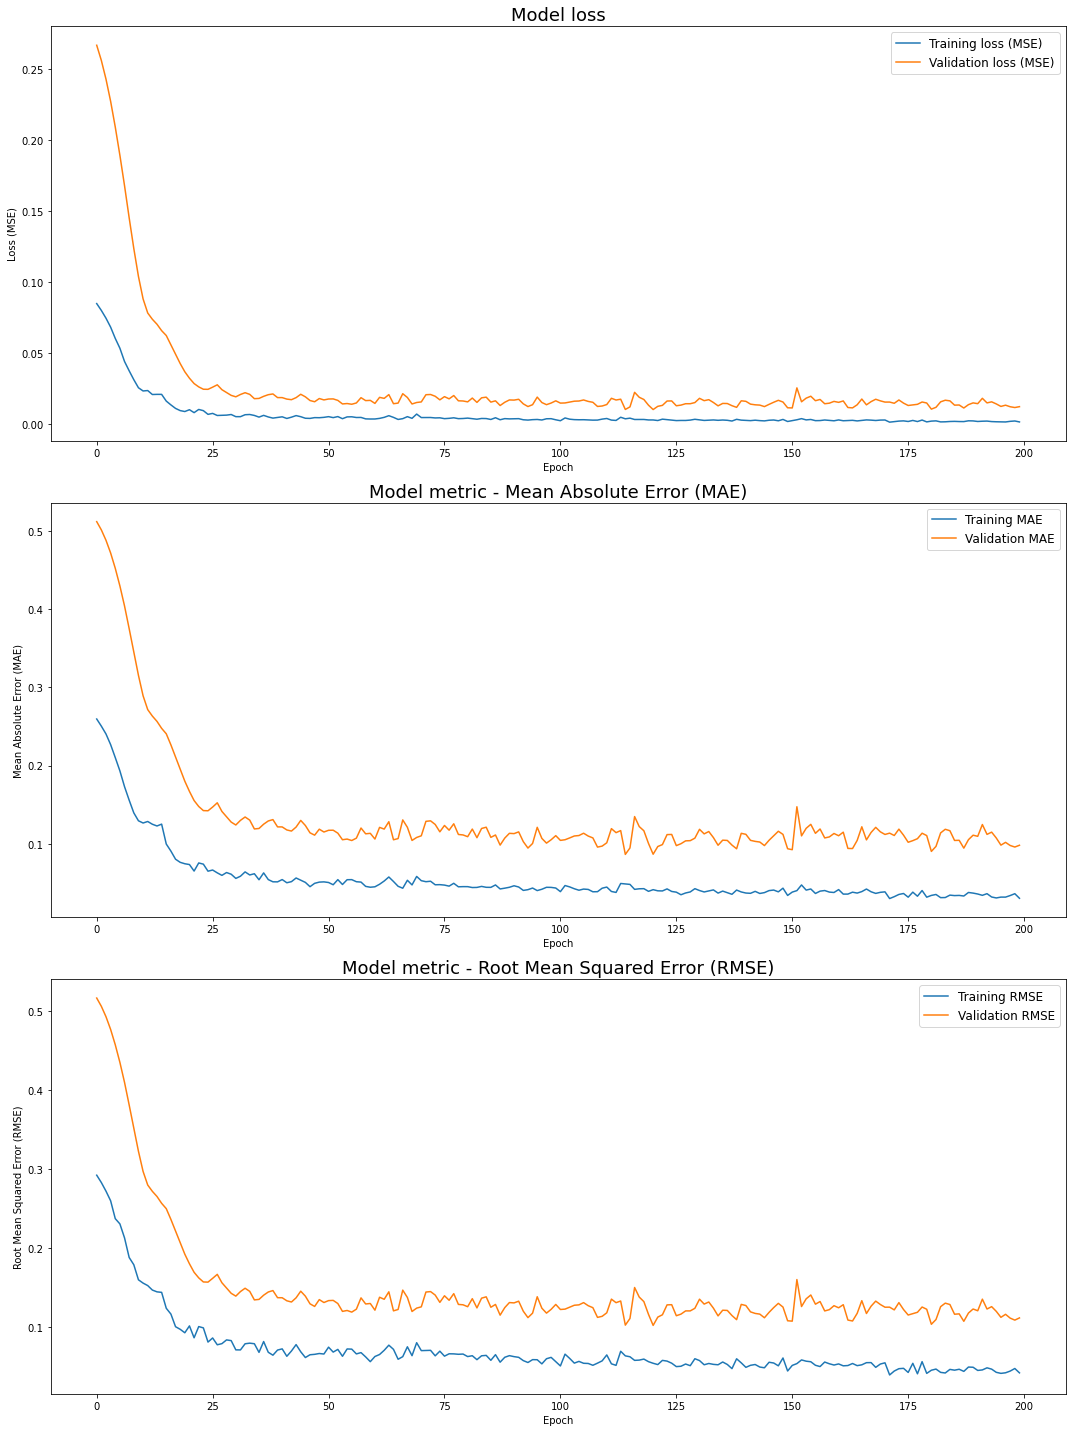

In [52]:
plot_metrics(history)